# FRED Data Time Series Analysis and Forecasting

## Modeling and Forecasting Trend, Seasonality, and Cycles


## Introduction

For our project, we took the 'Total Business Sales' and 'Total Business Inventories' data (in Millions of Dollars) from FRED 1992 onwards with a monthly frequency, with the intuition that there would be some Granger-causal relationship between them (we also run a preliminary check to confirm this). Both series seemed to possess all the 3 components- seasonality, trend and cyclicity. 

We attempt to analyse and decompose these series first to be able to build a model that captures all underlying dynamics and can be used to make forecasts comparable to ETS, Holt-Winters and Auto-ARIMA. We then fit a VAR model to these series to capture interdependicies and feedback effects.

This analysis has the potential to add value as it can be used to forecast future economic activity and help in making business/policy decisions.

In [131]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import statsmodels.formula.api as smf

In [132]:
# Importing the data

# fred = Fred(api_key='ee4b8758a9f21d577d76c0b8c779e7d7')

# sales = fred.get_series('TOTBUSSMNSA')
# inv = fred.get_series('TOTBUSIMNSA')

In [133]:
inv   = pd.read_csv('./TOTBUSIMNSA.csv', index_col='DATE')
sales = pd.read_csv('./TOTBUSSMNSA.csv', index_col='DATE')

inv.index = pd.to_datetime(inv.index, format="%Y/%m")
sales.index = pd.to_datetime(sales.index, format="%Y/%m/%d")

In [134]:
# Preliminary check for Granger-Causality in the two time series

from statsmodels.tsa.stattools import grangercausalitytests

df = pd.concat([sales, inv], axis = 1)
df.columns = ["Sales", "Inv"]
result = grangercausalitytests(df[["Sales", "Inv"]], maxlag=3)

#significant p-value- reject the null that there is no granger-causality


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=113.9649, p=0.0000  , df_denom=371, df_num=1
ssr based chi2 test:   chi2=114.8864, p=0.0000  , df=1
likelihood ratio test: chi2=100.1850, p=0.0000  , df=1
parameter F test:         F=113.9649, p=0.0000  , df_denom=371, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=52.1460 , p=0.0000  , df_denom=368, df_num=2
ssr based chi2 test:   chi2=105.7090, p=0.0000  , df=2
likelihood ratio test: chi2=93.0689 , p=0.0000  , df=2
parameter F test:         F=52.1460 , p=0.0000  , df_denom=368, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=49.5864 , p=0.0000  , df_denom=365, df_num=3
ssr based chi2 test:   chi2=151.6121, p=0.0000  , df=3
likelihood ratio test: chi2=127.1709, p=0.0000  , df=3
parameter F test:         F=49.5864 , p=0.0000  , df_denom=365, df_num=3


## (a) Produce a time-series plot of your data including the respective ACF and PACF plots.

## Time series plots

Text(0, 0.5, 'Inventories (Million Dollars)')

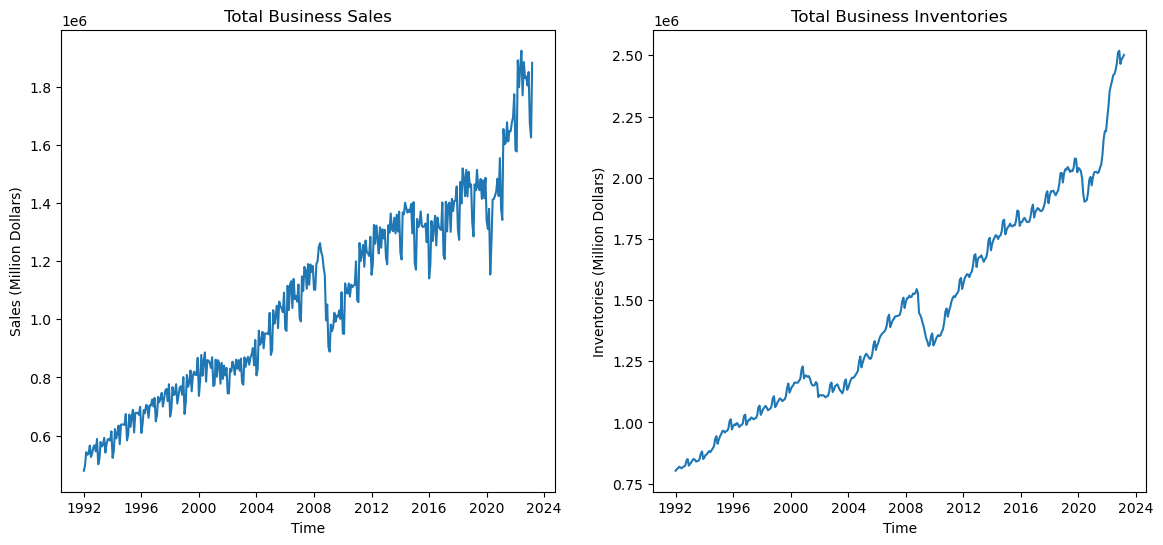

In [135]:
plt.figure(figsize = (14,6))

plt.subplot(1,2,1)
plt.plot(df["Sales"])
plt.title("Total Business Sales")
plt.xlabel("Time")
plt.ylabel("Sales (Million Dollars)")

plt.subplot(1,2,2)
plt.plot(df["Inv"])
plt.title("Total Business Inventories")
plt.xlabel("Time")
plt.ylabel("Inventories (Million Dollars)")

* For both the series, we see a somewhat linearly increasing trend from start to end. 
* There is clear seasonality, though its profile looks different for both. It seems to be more pronounced for the sales series. 
* We can also see the presence of cycles in both the series, characterized by dips that coincide with recession periods - around 2001, 2008 and 2020.   

Since the amplitude of seasonality seems to be changing over time, i.e. the data exhibit multiplicative seasonality, we do a log transformation on the series to equalize variance for the rest of the analysis.


In [136]:
# Log Transformation

lsales = np.log(sales)
linv = np.log(inv)

Text(0, 0.5, 'Log Inventories')

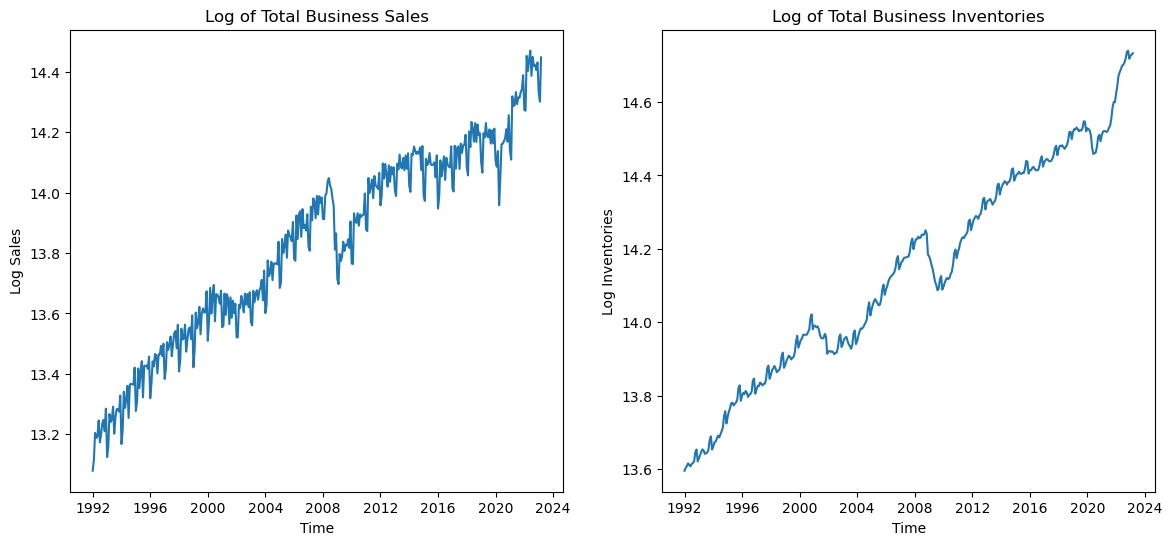

In [137]:
# Plotting log-transformed series

plt.figure(figsize = (14,6))

plt.subplot(1,2,1)
plt.plot(lsales)
plt.title("Log of Total Business Sales")
plt.xlabel("Time")
plt.ylabel("Log Sales")

plt.subplot(1,2,2)
plt.plot(linv)
plt.title("Log of Total Business Inventories")
plt.xlabel("Time")
plt.ylabel("Log Inventories")

As expected, the log-transformed series has relatively more stable variance. The rest of the observations still hold from the previous time series plots of the raw series. 

## ACF and PACF

### Sales data

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


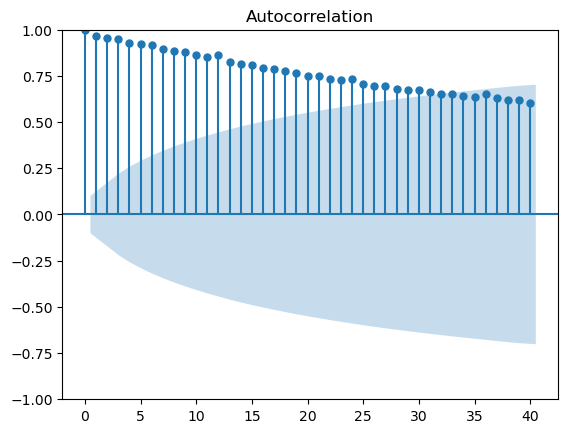

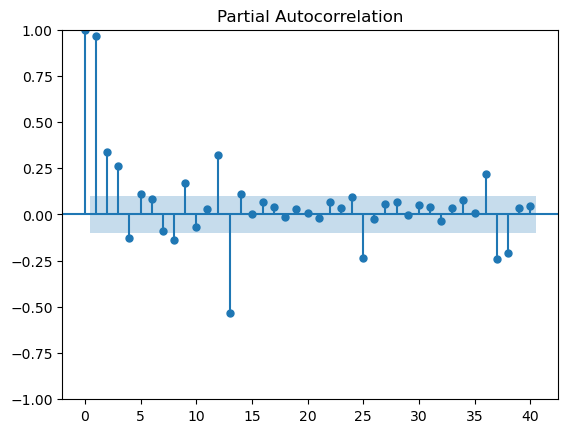

In [138]:
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot

plot_acf(lsales, lags = 40);
plot_pacf(lsales, lags = 40);

The ACF plot suggests high correlation of the series with its lags for almost 2.5 years. The significance gradually declines though. 

The PACF has significant spikes until lag 5 and then an overall dropoff. However, we have quite a few random significant spikes for later lags, especially around 12, 24 and 36 lags. This suggests the presence of seasonality in the series, which we know exists from the time series plot. 

Altogether, this looks like a Seasonal AR (S-AR) process of order ~4. 

## Inventories data

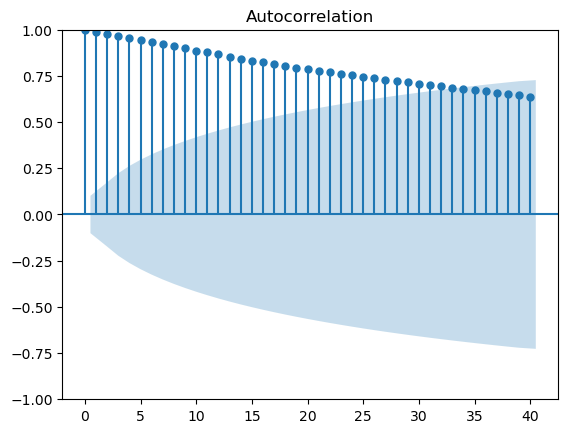

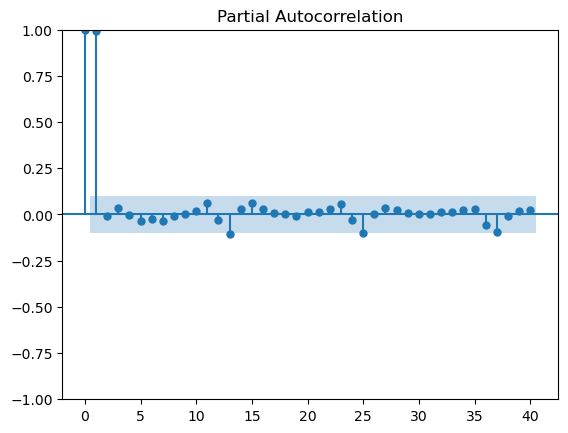

In [139]:
plot_acf(linv, lags = 40);
plot_pacf(linv, lags = 40);

The ACF plot for inventories is very similar to that for sales, showing high correlation with lagged values for ~2.5 years but with a gradual decay in significance of spikes.

The PACF only has one clear significant spike at lag 1 and then a sharp dropoff thereafter. However, the lags around 12, 24 and 36 have spikes that slightly cross the bands and so may be significant. These again suggest seasonality in the series. 

This too, looks like a Seasonal AR process of order 1.

## (b) Plot the STL decomposition plot of your data, and discuss the results.

In [140]:
from statsmodels.tsa.seasonal import STL

## Sales data

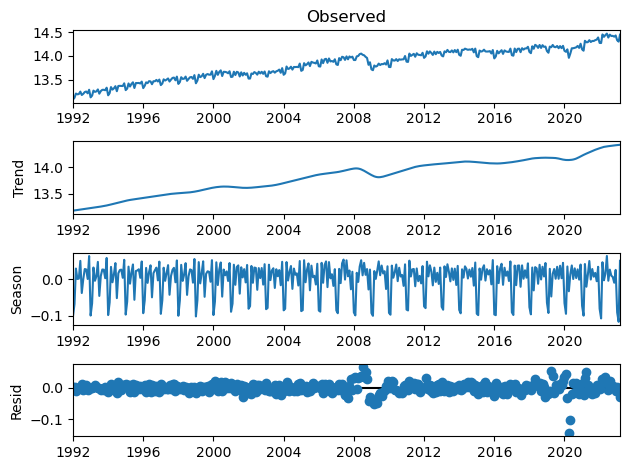

In [141]:
# Plotting the STL decomposition
stl = STL(lsales)
results = stl.fit()
fig = results.plot()

# The first plot below is the original series itself

The STL decomposition extracts the different components of the time series and outputs 4 plots- 


*   The original series itself
*   Trend: shows the long-term movement of the data which seems linearly increasing for the most part.
* Seasonality: The plot captures the regular patterns occurring within a year in the series. We can see how the yearly seasonality evolves from having a more noticeable blip in the middle of the year until 2008 to a relatively smoother pattern later. 
*   Residuals: shows information or signal in the series that is not captured as part of the trend or seasonality. Here, residuals seem to be centered around 0 for the most part, but since we have some outliers around recession periods, the variance is noisy here. This suggests the presence of cycles in the data which we attempt to model.





## Inventories data

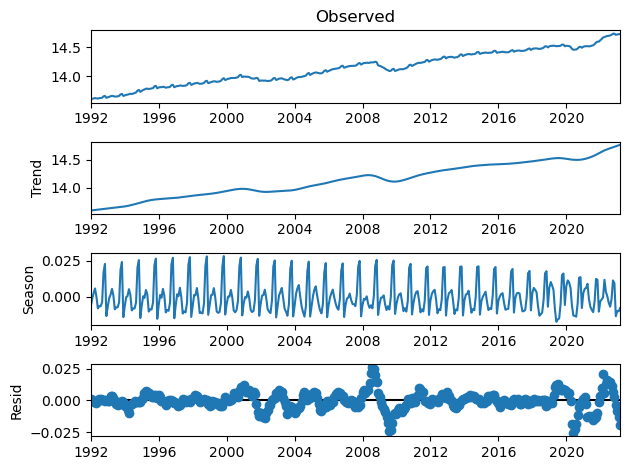

In [142]:
# Plotting the STL decomposition
stl = STL(linv)
results = stl.fit()
fig = results.plot()

# The first plot below is the original series itself



*   Trend: the inventories data too shows a linearly increasing long-term movement
* Seasonality: this captures the regular pattern in the data within a year which also shows some changes over time. For the first few years we see two peaks within a year- a smaller one led by a higher peak. Eventually, both the peaks seem to equalize.
*   Residuals: There is some pattern in the residuals and they don't seem to be randomly scattered around 0, suggesting the presence of cycles. Again, the recession periods are particularly noisy. We attempt to model this remainder in the series (using AR).




## (c) Fit a model that includes, trend, seasonality and cyclical components (not from auto.arima). Make sure to discuss your model in detail.

In [143]:
from statsmodels.tsa.arima.model import ARIMA

## Sales data-

In [144]:
model_sales = ARIMA(lsales, order=(4, 1, 0), seasonal_order = (3, 0, 0, 12),
              trend = (0, 1, 0)).fit()

print(model_sales.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:                      TOTBUSSMNSA   No. Observations:                  375
Model:             ARIMA(4, 1, 0)x(3, 0, 0, 12)   Log Likelihood                 795.242
Date:                          Fri, 19 May 2023   AIC                          -1572.484
Time:                                  15:32:27   BIC                          -1537.166
Sample:                              01-01-1992   HQIC                         -1558.461
                                   - 03-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0044      0.011      0.404      0.686      -0.017       0.026
ar.L1         -0.2706      0.041     -6.553      0.

After referring to the ACF and PACF plots, we use a SARIMA (Seasonal Auto Regressive Integrated Moving Average) model to capture the trend, seasonality and cycles in our data. 

*Specification of the order of the model was an iterative process and we finalized this model based on the diagnostics discussed in the succeeding parts. We also experimented with adding exogenous seasonal dummies but for our data, the above model seems to perform the best.*

For cycles or the non-seasonal component, we fit an AR(4) model since the PACF had a dropoff after 4 lags (lag 5 slightly crossed the band but we start with a lower order and could consider adding more lags if needed). We also include a differencing component of order 1 to achieve stationarity in the series. Since the data is not characteristic of an MA process, we don't fit an MA model (q = 0).

For seasonality, we fit a seasonal autoregressive component of order 3 (SAR(3)), again based on the ACF and PACF which showed significant spikes in the latetr at lags 12, 24 and 36. We don't include seasonal differencing or a seasonal moving average component (SMA(0)) at this stage. The seasonal period is specified as 12 since we have monthly data. 

For the trend, we cannot include a constant since we difference the series. We fit a linear trend which seems to fit the data well from the STL decomposition.

Looking at the p-values, all but 2 parameters are highly statistically significant with p-values of 0. The trend parameter (x1) is statistically insignificant. This could be beause once we difference the data, the trend doesn't help explain much of the dynamics. It could also be because some other component (cycles or seasonality) is picking up on the effect of the trend and so there isn't much left to capture with the additional trend term. The SAR lag 24 also turns out to be insignificant.   

## Inventories data-

In [145]:
model_inv = ARIMA(linv, order=(1, 1, 0), seasonal_order = (3, 0, 0, 12),
              trend = (0, 1, 0)).fit()

print(model_inv.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                      TOTBUSIMNSA   No. Observations:                  375
Model:             ARIMA(1, 1, 0)x(3, 0, 0, 12)   Log Likelihood                1426.747
Date:                          Fri, 19 May 2023   AIC                          -2841.495
Time:                                  15:32:37   BIC                          -2817.949
Sample:                              01-01-1992   HQIC                         -2832.146
                                   - 03-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0039      0.006      0.596      0.551      -0.009       0.017
ar.L1          0.6600      0.033     20.051      0.

Here too, we fit a SARIMA to capture the underlying dynamics of trend, seasonality and cyclicity in the data, after consulting the ACF and PACF plots of the series to determine the model and its order.

For cycles or the non-seasonal component, we fit an AR(1) model since there was only significant spike at lag 1 in the PACF. We also difference the data once to make it stationary. There is no MA term included in this model since it doesn't seem apposite for our data. 

For seasonality, similar to the sales data, we fit an SAR of order 3, since the PACF again had siginifcant spikes at 12-month intervals for 3 years. We don't include seasonal differencing or a seasonal moving average component (SMA) at this stage. The seasonal period is specified as 12 since we have monthly data. 

We model the trend similar to the sales data model, with a linear term.

Here too, most of our parameters are highly statistically significant. The trend term is again insignificant, probably because of the differencing or because of the other components capturing all the information in the series already. 

## (e) Plot the respective residuals vs. fitted values and discuss your observations.

## Sales data-

In [146]:
# Extracting residuals
res_sales = pd.DataFrame(model_sales.resid[1:])

# Extracting fitted values
fv_sales = pd.DataFrame(model_sales.fittedvalues[1:])

For the trend, we cannot include a constant since we difference the series. We fit a linear trend which seems to fit the data well from the STL decomposition.

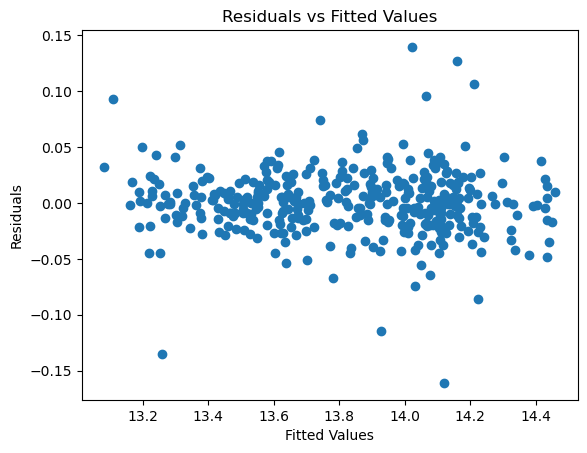

In [147]:
# Plotting residuals vs fitted values

plt.scatter(fv_sales, res_sales)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

The residuals vs fitted values plot seems to be centered around 0, although there isn't a pure random scatter. We can spot some outliers which contribute to non-constant variance in the residuals. Nevertheless, there doesn't seem to be a discernible pattern. Since achieving a perfect residuals plot is often challenging, we complement this with other diagnostic plots below to gauge our model's fit.

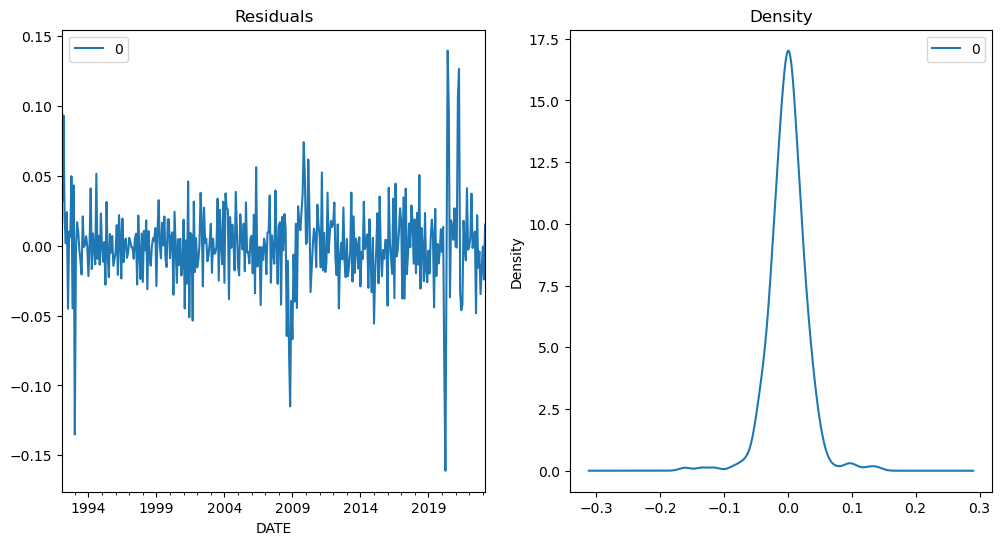

                0
count  374.000000
mean     0.000154
std      0.029454
min     -0.161021
25%     -0.015001
50%      0.000275
75%      0.015779
max      0.139680


In [148]:
# More diagnostics

fig, ax = plt.subplots(1, 2, figsize = (12,6))

res_sales.plot(title="Residuals", ax=ax[0])
res_sales.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
print(res_sales.describe())

The residuals have a mean of ~0. Apart from recession periods where the data fluctuates a lot and causes high variance in the residuals, they seem pretty close to a white noise process. We later look at the ACF and PACF of the residuals to see if we have any significant spikes which we could use to refine the model.

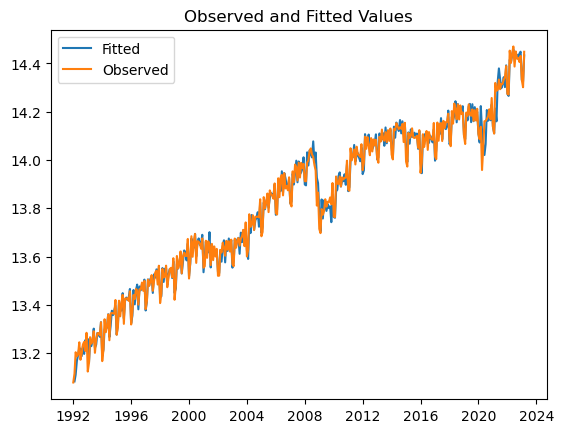

In [149]:
# Plotting fitted values and observed values
plt.title("Observed and Fitted Values")
plt.plot(fv_sales, label = "Fitted")
plt.plot(lsales, label = "Observed")
plt.legend()

We can see from the above plot that are fitted values align pretty well with our observed values, suggetsing that the model is doing a pretty good job.

## Inventories data-

In [150]:
# Extracting residuals
res_inv = pd.DataFrame(model_inv.resid[1:])

# Extracting fitted values
fv_inv = pd.DataFrame(model_inv.fittedvalues[1:])

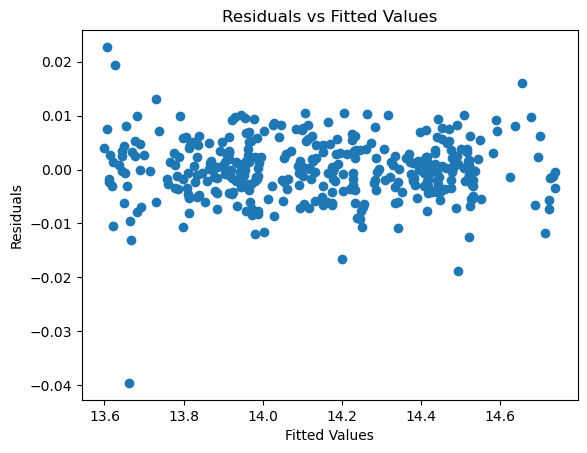

In [151]:
plt.scatter(fv_inv, res_inv)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

The residuals seem centered around 0 and also mostly randomly scattered. There are a few outliers and there seems to be slight heteroskedasticity. However, overall, the plot looks good.

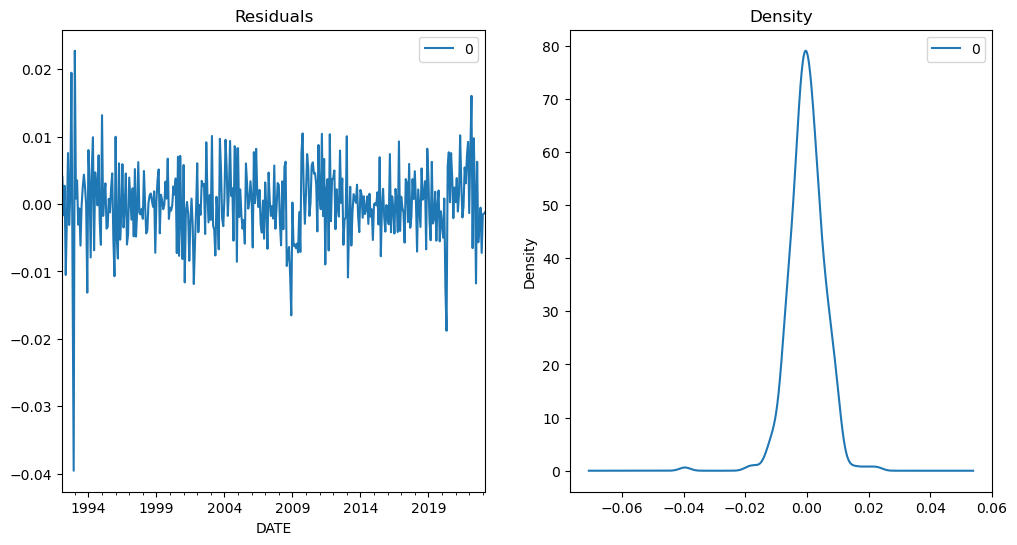

                0
count  374.000000
mean     0.000154
std      0.029454
min     -0.161021
25%     -0.015001
50%      0.000275
75%      0.015779
max      0.139680


In [152]:
# More diagnostics

fig, ax = plt.subplots(1, 2, figsize = (12,6))

res_inv.plot(title="Residuals", ax=ax[0])
res_inv.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
print(res_sales.describe())

The mean is again ~0. Recession periods cause high variance in the residuals. It looks like there may still be some cyclicity left over to model but we first look at the ACF and PACF of the residuals to decide that.

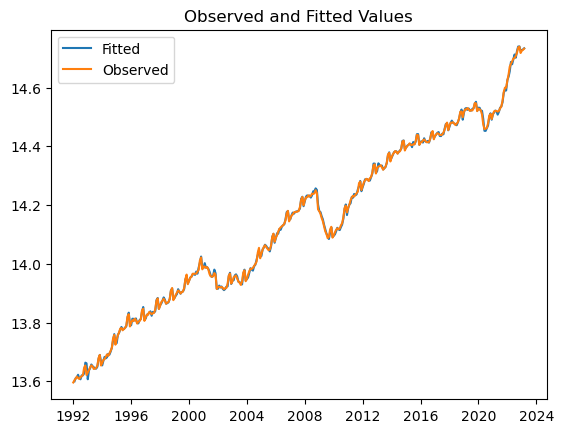

In [153]:
# Plotting fitted values and observed values
plt.title("Observed and Fitted Values")
plt.plot(fv_inv)
plt.plot(linv)
plt.legend(["Fitted", "Observed"])

Fitted values overlap almost perfectly with observed values.

## (f) Plot the ACF and PACF of the respective residuals and interpret the plots.

## Sales data-

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


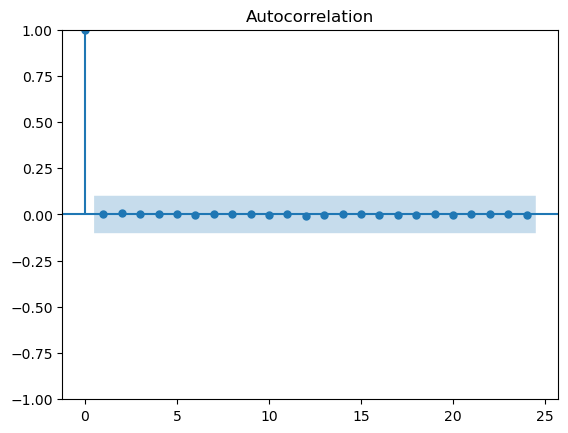

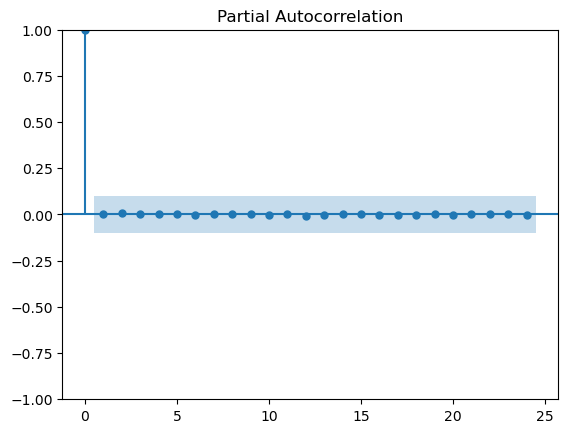

In [154]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(model_sales.resid, lags = 24)
plot_pacf(model_sales.resid, lags = 24) 
plt.show()

There is no significant spike in the residuals' ACF or PACF plots, indicating that the model does a good job at extracting whatever dynamics there were to model in the data.

## Inventories data-

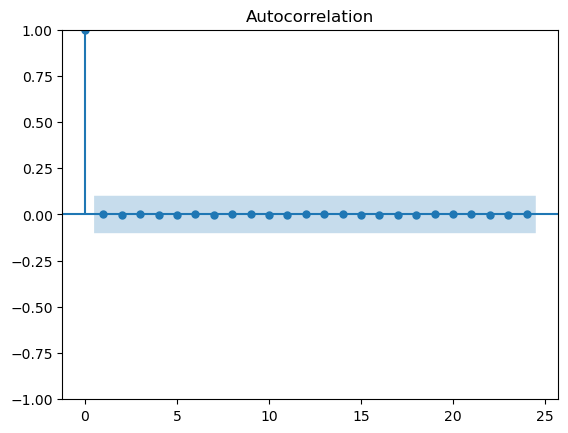

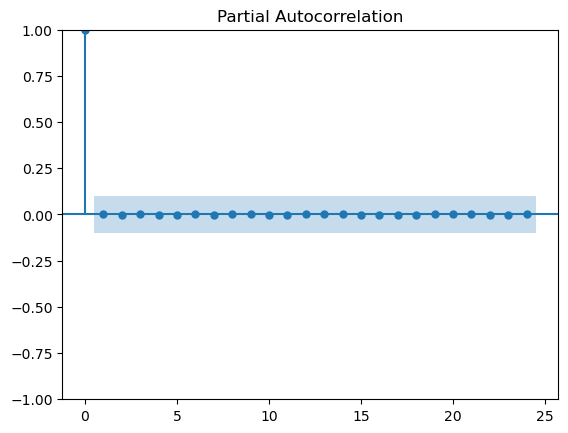

In [155]:
plot_acf(model_inv.resid, lags = 24)
plot_pacf(model_inv.resid, lags = 24) 
plt.show()

For inventories data as well, there are no significant spikes suggesting that there are no left over significant correlations and the residuals are independent of each other. 

## (g.)  Plot the respective CUSUM and interpret the plot.

Note: the originally specified SARIMA model contains a difference, which recursive_olsresiduals cannot handle, so I transform the original data to a differenced series then run the same model without a difference.

In [156]:
# Convert to a model that recursive residuals can handle
lsales_dif = lsales - lsales.shift(1)
lsales_dif = lsales_dif.dropna()
model_sales_dif = ARIMA(lsales_dif, order=(4, 0, 0), seasonal_order = (3, 0, 0, 12),  # changed first terms from (4,1,0) to (4,0,0)
              trend = (0, 1, 0)).fit()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Text(0, 0.5, 'Empirical Fluctuation Process')

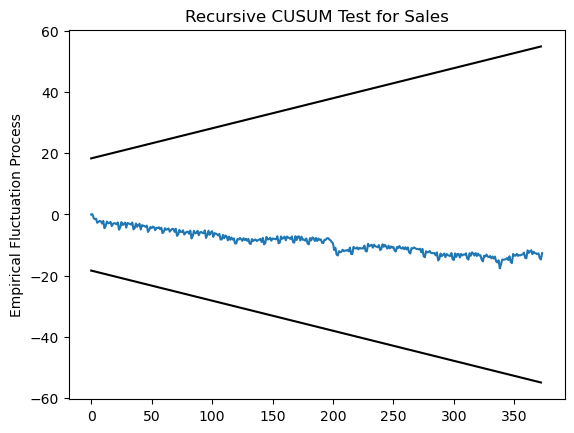

In [157]:
# Compute the recursive residuals
from statsmodels.stats.diagnostic import recursive_olsresiduals

recursive_resid = recursive_olsresiduals(model_sales_dif)


plt.title('Recursive CUSUM Test for Sales')

# pull out and plot the first band of the CI
plt.plot(recursive_resid[6][0], color = 'black')

# pull out and plot the cusum test values
plt.plot(recursive_resid[5])

# pull out and plot the second band of the CI
plt.plot(recursive_resid[6][1], color = 'black')
plt.ylabel('Empirical Fluctuation Process')

The recursive residual cumulative sum trends slightly downward, however, it does not breach the limits that indicate structural breaks. Thus the custom model adequately handles cycles with autoregressive parameters.

In [158]:
linv_dif = linv - linv.shift(1)
linv_dif = linv_dif.dropna()
model_inv_dif = ARIMA(linv_dif, order=(1, 0, 0), seasonal_order = (3, 0, 0, 12),
              trend = (0, 1, 0)).fit()

print(model_inv_dif.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                      TOTBUSIMNSA   No. Observations:                  374
Model:             ARIMA(1, 0, 0)x(3, 0, 0, 12)   Log Likelihood                1337.565
Date:                          Fri, 19 May 2023   AIC                          -2663.130
Time:                                  15:32:57   BIC                          -2639.584
Sample:                              02-01-1992   HQIC                         -2653.781
                                   - 03-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          8.674e-06   9.43e-06      0.920      0.358   -9.81e-06    2.72e-05
ar.L1          0.0719      0.047      1.544      0.

Text(0, 0.5, 'Empirical Fluctuation Process')

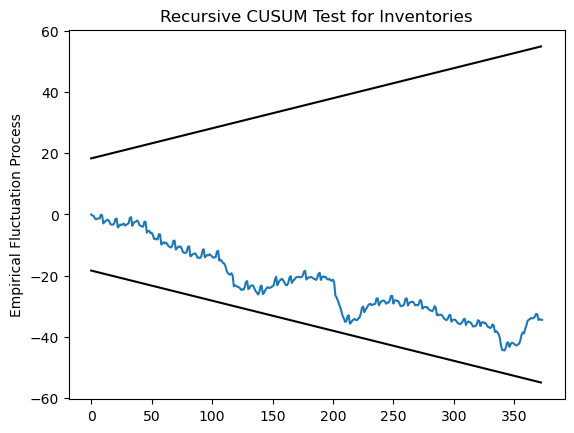

In [159]:
# Compute the recursive residuals
from statsmodels.stats.diagnostic import recursive_olsresiduals

recursive_resid = recursive_olsresiduals(model_inv_dif)


plt.title('Recursive CUSUM Test for Inventories')

# pull out and plot the first band of the CI
plt.plot(recursive_resid[6][0], color = 'black')

# pull out and plot the cusum test values
plt.plot(recursive_resid[5])

# pull out and plot the second band of the CI
plt.plot(recursive_resid[6][1], color = 'black')
plt.ylabel('Empirical Fluctuation Process')

The recursive residual cumulative sum trends downward somewhat strongly, however, it does not breach the limits that indicate structural breaks. Thus the custom model handles cycles with autoregressive parameters.

## (h) For your model, discuss the associated diagnostic statistics.

In [160]:
model_sales.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                      TOTBUSSMNSA   No. Observations:                  375
Model:             ARIMA(4, 1, 0)x(3, 0, 0, 12)   Log Likelihood                 795.242
Date:                          Fri, 19 May 2023   AIC                          -1572.484
Time:                                  15:32:58   BIC                          -1537.166
Sample:                              01-01-1992   HQIC                         -1558.461
                                   - 03-01-2023                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0044      0.011      0.404      0.686      -0.017       0.026
ar.L1         -0.2706      0.041     -6.553      0.000      -0.352      -0.190
ar.L2         -0.1673      0.032     -5.187      0.000      -0.230      -0.104
ar.L3          0.2415      0.035      6.973      0.000       0.174       0.309
ar.L4         -0.1518      0.042     -3.584      0.000      -0.235      -0.069
ar.S.L12       0.5396      0.035     15.380      0.000       0.471       0.608
ar.S.L24       0.0819      0.068      1.199      0.230      -0.052       0.216
ar.S.L36       0.3082      0.072      4.295      0.000       0.168       0.449
sigma2         0.0008   4.44e-05     17.722      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               574.70
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.16   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Sales:

Our custom model has an AIC = -1572 and BIC = -1537. Later we implement autoarima and the best performing model has comparable AIC of -1492.
Coefficients for all factors (AR lag 1-4, Seasonal 12 lag 1/3) except 2 year seasonal lag are statistically significant in forecasting sales. Referencing the Ljung-Box test statistic which has a null hypothesis that residuals are dependent, we fail to reject null hypothesis (prob(Q) = 0.94). Based on the Jarque-Bera statistic (prob(JB) = 0.00), we reject the null hypothesis that residuals are normally distributed.

In [161]:
model_inv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                      TOTBUSIMNSA   No. Observations:                  375
Model:             ARIMA(1, 1, 0)x(3, 0, 0, 12)   Log Likelihood                1426.747
Date:                          Fri, 19 May 2023   AIC                          -2841.495
Time:                                  15:33:09   BIC                          -2817.949
Sample:                              01-01-1992   HQIC                         -2832.146
                                   - 03-01-2023                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0039      0.006      0.596      0.551      -0.009       0.017
ar.L1          0.6600      0.033     20.051      0.000       0.596       0.725
ar.S.L12       0.3931      0.053      7.358      0.000       0.288       0.498
ar.S.L24       0.1917      0.061      3.163      0.002       0.073       0.311
ar.S.L36       0.3266      0.058      5.608      0.000       0.212       0.441
sigma2      2.693e-05   2.04e-06     13.168      0.000    2.29e-05    3.09e-05
===================================================================================
Ljung-Box (L1) (Q):                   4.76   Jarque-Bera (JB):                17.61
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.22
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Inventory: 

Our custom model has an AIC = -2841 and BIC = -2818. Later we implement autoarima and the best performing model has comparable AIC of -2744.
Coefficients for all factors are statistically significant in forecasting inventories. The Ljung-Box statistic indicates errors are uncorrelated (prob(Q) = 0.03). Based on the Jarque-Bera statistic (prob(JB) = 0.00), we reject the null hypothesis that residuals are normally distributed.

## (i.) Use your model to forecast 12-steps ahead. 

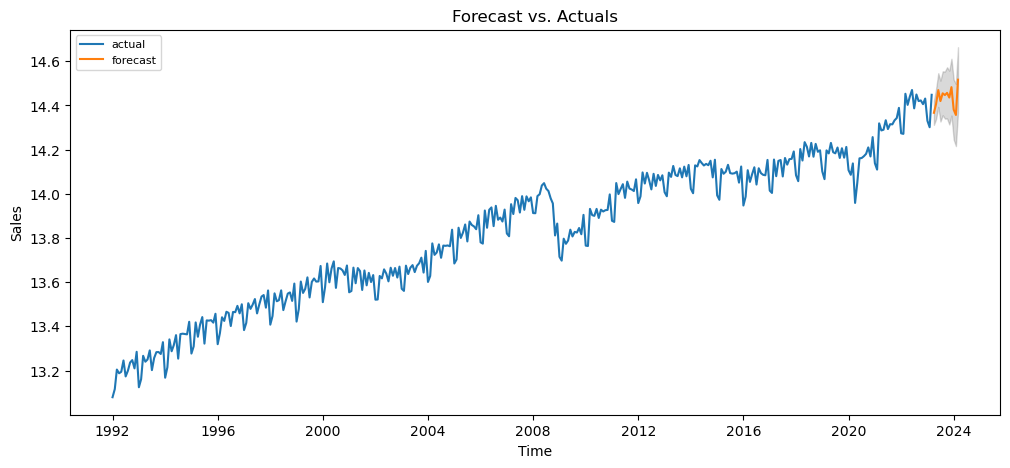

In [ ]:
# Forecast SALES
fc = model_sales.forecast(12, alpha=0.05) # 95% conf

# Confidence
lower_series = model_sales.get_forecast(12).conf_int().iloc[:,0]
upper_series = model_sales.get_forecast(12).conf_int().iloc[:,1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(lsales, label='actual')
plt.plot(fc, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('SALES Forecast vs. Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Sales')
plt.show()

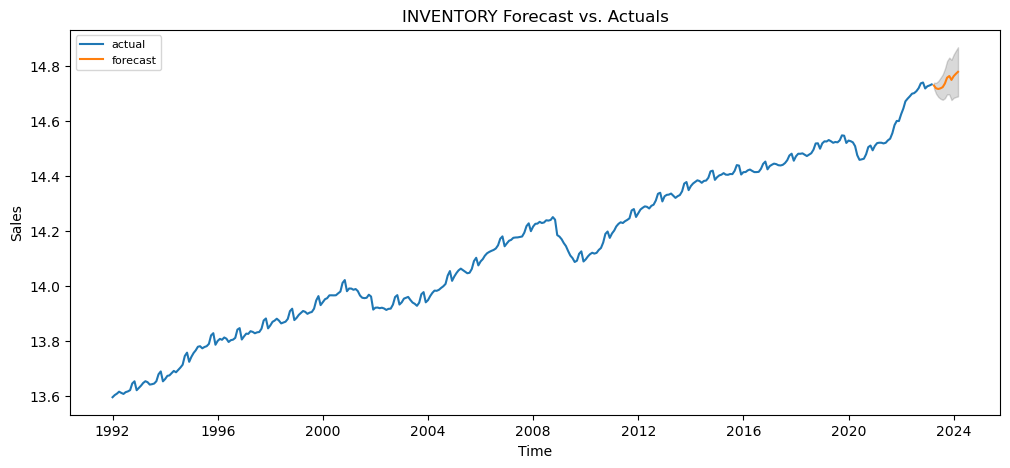

In [98]:
# Forecast INVENTORIES
fc = model_inv.forecast(12, alpha=0.05) # 95% conf

# Confidence
lower_series = model_inv.get_forecast(12).conf_int().iloc[:,0]
upper_series = model_inv.get_forecast(12).conf_int().iloc[:,1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(linv, label='actual')
plt.plot(fc, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('INVENTORY Forecast vs. Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Sales')
plt.show()

## (j) Compare your forecast from (i) to the 12-steps ahead forecasts from auto.arima, ets, and Holt-Winters models. Which model performs best in terms of MAPE? 

Note: For computing MAPE, you can use the last 12 observations as your test sample.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-1496.882, Time=1.39 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-908.050, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-1397.390, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-1204.044, Time=1.01 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-807.222, Time=0.02 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-1395.921, Time=0.41 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.57 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=11.45 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-1412.791, Time=1.17 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=13.42 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-1460.045, Time=0.89 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-1432.437, Time=1.77 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-1492.349, Time=2.29 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-921.151, Time=0.59 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=-1247.670, Time=1.11 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-1488.667, Time=0.86 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-1493.173, Time=2.12 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/exponential_smoothing.py:161: RuntimeWarning: ExponentialSmoothing should not be used with seasonal terms. It has a serious bug that has not been fixed. Instead use ETSModel.
  warnings.warn(
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


 ARIMA(1,0,1)(0,1,1)[12]             : AIC=-1492.202, Time=0.91 sec

Best model:  ARIMA(1,0,1)(0,1,1)[12] intercept
Total fit time: 41.560 seconds
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59220D+00    |proj g|=  3.83639D-01

At iterate    5    f= -2.11165D+00    |proj g|=  1.22599D-01

At iterate   10    f= -2.17387D+00    |proj g|=  6.14955D-03

At iterate   15    f= -2.17509D+00    |proj g|=  1.91429D-04

At iterate   20    f= -2.17513D+00    |proj g|=  8.15414D-05

At iterate   25    f= -2.17513D+00    |proj g|=  2.73243D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient


Text(0, 0.5, 'Log Sales')

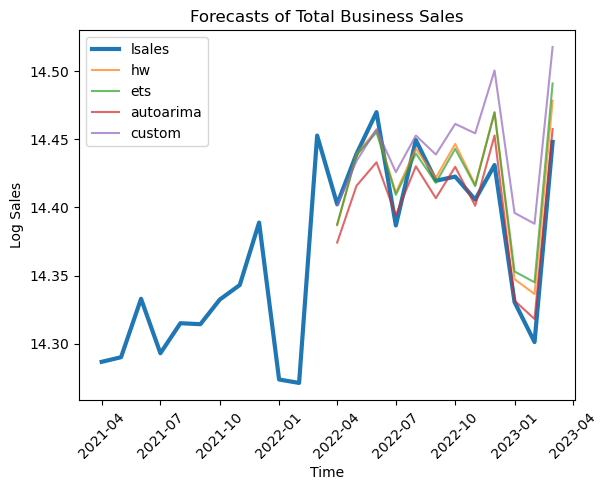

In [ ]:
# Sales

# Custom forecast --------------------------------
custom_model = ARIMA(lsales[:-12], order=(4, 1, 0), seasonal_order = (3, 0, 0, 12),
                     trend = (0, 1, 0)).fit()
custom_cast = custom_model.forecast(12)



# Autoarima Forecast ----------------------------
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(lsales[:-12], start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

# Predict and Format
auto_cast = smodel.predict(12)
auto_cast = pd.Series(auto_cast)
auto_cast.index = lsales.index[-12:]



# ETS Forecast -----------------------------------
lsales = lsales.resample("M").first()  # date format is finicky for ETS
import statsmodels.api as sm
ets_model=sm.tsa.statespace.ExponentialSmoothing(lsales[:-12],
                                           trend=True, 
                                           freq='M',
                                           initialization_method= 'heuristic', 
                                           seasonal=12, 
                                           damped_trend=False).fit()
lsales.index = pd.Series(lsales.index).apply(lambda dt: dt.replace(day=1)) # reformat to first of month

ets_cast = ets_model.forecast(12)
ets_cast.index = pd.Series(ets_cast.index).apply(lambda dt: dt.replace(day=1))


# Holt-Winters Forecast ----------------------------
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
hw_model = HWES(lsales[:-12], seasonal_periods=12, trend='add', seasonal='mul')
hw_fitted = hw_model.fit()

hw_cast = hw_fitted.forecast(12)


# Plot
plt.plot(lsales[-24:], linewidth=3, label='lsales')
plt.plot(hw_cast[-24:], alpha = 0.7, label='hw')
plt.plot(ets_cast[-24:], alpha = 0.7, label='ets')
plt.plot(auto_cast[-24:], alpha = 0.7, label='autoarima')
plt.plot(custom_cast[-24:], alpha = 0.7, label='custom')
plt.legend()
plt.title("Forecasts of Total Business Sales")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.ylabel("Log Sales")

In [ ]:
# Sales MAPEs
real = lsales[-12:]['TOTBUSSMNSA']

hw_mape     = np.mean( np.abs(real - hw_cast) / real )
ets_mape    = np.mean( np.abs(real - ets_cast) / real )
auto_mape   = np.mean( np.abs(real - auto_cast) / real )
custom_mape = np.mean( np.abs(real - custom_cast) / real )

print('MAPES: ')
print('HW: ', round(hw_mape, 4), 'ETS: ', round(ets_mape, 4))
print('AutoARIMA: ', round(auto_mape, 4), 'Custom Model: ', round(custom_mape,4))

MAPES: 
HW:  0.0013 ETS:  0.0014
AutoARIMA:  0.0011 Custom Model:  0.0027


In [89]:
# Custom forecast --------------------------------
custom_model = ARIMA(linv[:-12], order=(1, 1, 0), seasonal_order = (3, 0, 0, 12),
              trend = (0, 1, 0)).fit()
custom_cast = custom_model.forecast(12)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [91]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(linv[:-12], start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-2682.161, Time=1.78 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-1190.187, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-1038.578, Time=0.02 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-2551.759, Time=0.20 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-2659.545, Time=2.87 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-2676.761, Time=17.03 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-2608.733, Time=0.97 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=-2679.947, Time=12.78 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-2543.513, Time=1.41 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-2771.277, Time=1.40 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=-2678.244, Time=0.17 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=-2756.579, Time=1.20 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=-2777.465, Time=25.32 sec
 ARIMA(2,0,1)(1,1,2)[12] intercept   : AIC=-2774.531, Time=24.72 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=-2758.522, Time=8.32 sec
 ARIMA(3,0,1)(0,1,2)[12] intercept   : AIC=-2759.150, Time=17.28 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-2765.599, Time=14.07 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-2541.795, Time=16.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-2693.086, Time=19.99 sec
 ARIMA(3,0,0)(0,1,2)[12] intercept   : AIC=-2769.570, Time=16.26 sec
 ARIMA(3,0,2)(0,1,2)[12] intercept   : AIC=-2784.934, Time=29.95 sec
 ARIMA(3,0,2)(0,1,1)[12] intercept   : AIC=-2786.212, Time=2.49 sec
 ARIMA(3,0,2)(0,1,0)[12] intercept   : AIC=-2691.862, Time=0.60 sec
 ARIMA(3,0,2)(1,1,1)[12] intercept   : AIC=-2788.814, Time=5.43 sec
 ARIMA(3,0,2)(1,1,0)[12] intercept   : AIC=-2745.844, Time=2.43 sec
 ARIMA(3,0,2)(2,1,1)[12] intercept   : AIC=-2778.016, Time=26.95 sec
 ARIMA(3,0,2)(1,1,2)[12] intercept   : AIC=-2759.046, Time=14.10 sec
 ARIMA(3,0,2)(2,1,0)[12] intercept   : AIC=-2676.815, Time=11.94 sec
 ARIMA(3,0,2)(2,1,2)[12] intercept   : AIC=-2783.629, Time=33.69 sec
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-2737.875, Time=2.35 sec
 ARIMA(3,0,1)(1,1,1)[12] intercept   : AIC=-2737.444, Time=3.77 sec
 ARIMA(4,0,2)(1,1,1)[12] intercept   : AIC=-2745.981, Time=3.59 sec
 ARIMA(3,0,3)(1,1,1)[12] intercept   : AI

In [92]:
# Predict and Format
auto_cast = smodel.predict(12)
auto_cast = pd.Series(auto_cast)
auto_cast.index = linv.index[-12:]

In [93]:
# ETS Forecast -----------------------------------
linv = linv.resample("M").first()  # date format is finicky for ETS
import statsmodels.api as sm
ets_model=sm.tsa.statespace.ExponentialSmoothing(linv[:-12],
                                           trend=True, 
                                           freq='M',
                                           initialization_method= 'heuristic', 
                                           seasonal=12, 
                                           damped_trend=False).fit()
linv.index = pd.Series(linv.index).apply(lambda dt: dt.replace(day=1)) # reformat to first of month

ets_cast = ets_model.forecast(12)
ets_cast.index = pd.Series(ets_cast.index).apply(lambda dt: dt.replace(day=1))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.02241D+00    |proj g|=  5.99223D-01

At iterate    5    f= -3.71097D+00    |proj g|=  2.75168D-03

At iterate   10    f= -3.83190D+00    |proj g|=  3.12660D-02

At iterate   15    f= -3.84070D+00    |proj g|=  1.12292D-03

At iterate   20    f= -3.84101D+00    |proj g|=  2.32603D-04

At iterate   25    f= -3.84102D+00    |proj g|=  2.26286D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     35      1     0     0   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/exponential_smoothing.py:161: RuntimeWarning: ExponentialSmoothing should not be used with seasonal terms. It has a serious bug that has not been fixed. Instead use ETSModel.
  warnings.warn(
 This problem is unconstrained.


In [94]:
# Holt-Winters Forecast ----------------------------
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
hw_model = HWES(linv[:-12], seasonal_periods=12, trend='add', seasonal='mul')
hw_fitted = hw_model.fit()

hw_cast = hw_fitted.forecast(12)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Text(0, 0.5, 'Log Sales')

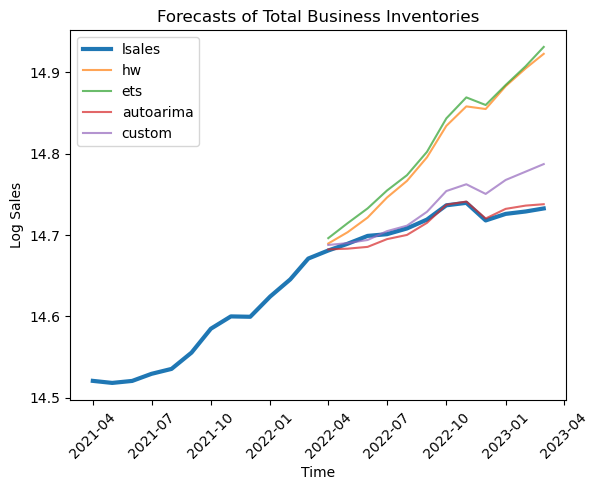

In [99]:
# Plot
plt.plot(linv[-24:], linewidth=3, label='lsales')
plt.plot(hw_cast[-24:], alpha = 0.7, label='hw')
plt.plot(ets_cast[-24:], alpha = 0.7, label='ets')
plt.plot(auto_cast[-24:], alpha = 0.7, label='autoarima')
plt.plot(custom_cast[-24:], alpha = 0.7, label='custom')
plt.legend()
plt.title("Forecasts of Total Business Inventories")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.ylabel("Log Sales")

In [96]:
# Inventories MAPEs
real = linv[-12:]['TOTBUSIMNSA']

hw_mape     = np.mean( np.abs(real - hw_cast) / real )
ets_mape    = np.mean( np.abs(real - ets_cast) / real )
auto_mape   = np.mean( np.abs(real - auto_cast) / real )
custom_mape = np.mean( np.abs(real - custom_cast) / real )

print('MAPES: ')
print('HW: ', round(hw_mape, 4), 'ETS: ', round(ets_mape, 4))
print('AutoARIMA: ', round(auto_mape, 4), 'Custom Model: ', round(custom_mape,4))

MAPES: 
HW:  0.0062 ETS:  0.0067
AutoARIMA:  0.0004 Custom Model:  0.0014


Autoarima is the best fitting model, with our custom model performing second best. 

### (k) Fit an appropriate VAR model using two variables. Show relevant plots and discuss results from the fit.

In [103]:
#Begin with ADF test for covariance stationarity
from statsmodels.tsa.stattools import adfuller
# Implementation with a constant and trend
adfuller(df.Sales, regression = 'ct')

(-4.60216613281448,
 0.001022474293917546,
 16,
 358,
 {'1%': -3.9842827222514656,
  '5%': -3.422825179481108,
  '10%': -3.1343034589585725},
 8505.644066370489)

In [104]:
adfuller(df.Inv, regression = 'ct')

(-1.6890228367352307,
 0.7556636741310989,
 17,
 357,
 {'1%': -3.9843548259642185,
  '5%': -3.4228599354097655,
  '10%': -3.1343238655389656},
 7453.704401910058)

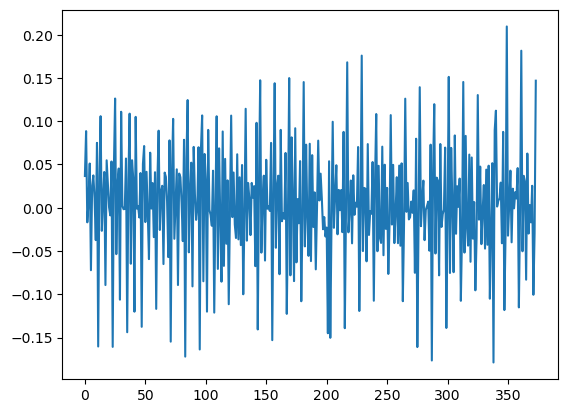

In [105]:
#Based on a visual analysis and the Inv series ADF test, data does not appear covariance stationary.
#Compute the first difference and log transform before fitting VAR model.

df_diff_Sales = np.diff(np.log(df['Sales']))
plt.plot(df_diff_Sales)

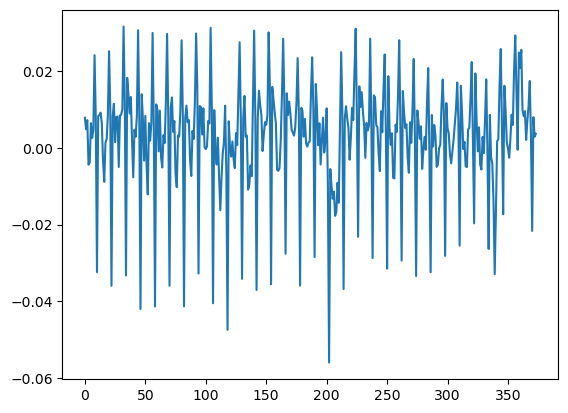

In [106]:
df_diff_Inv = np.diff(np.log(df['Inv']))
plt.plot(df_diff_Inv)

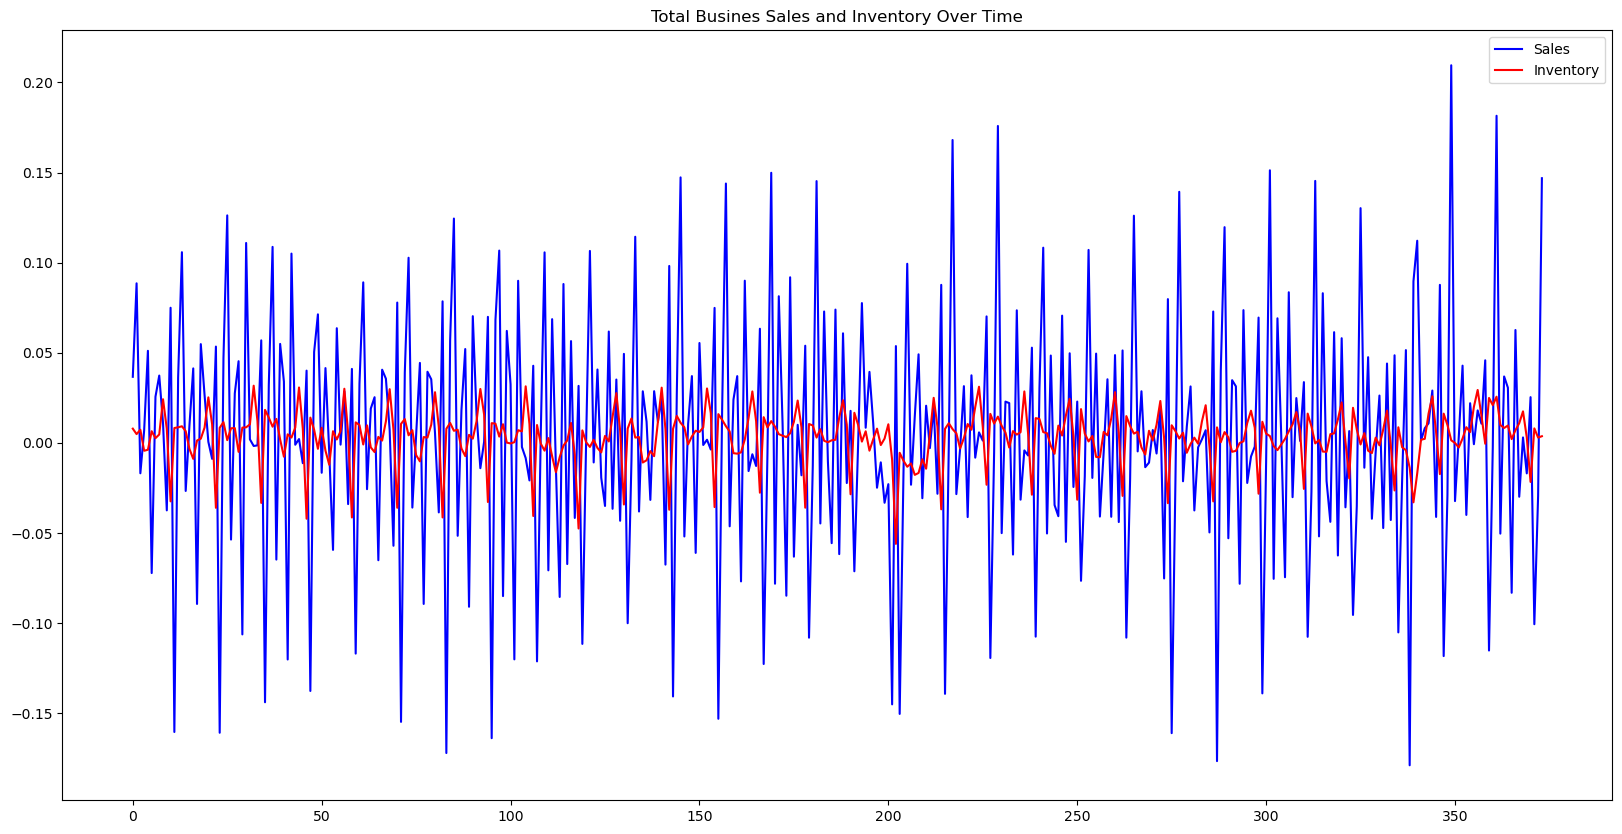

In [107]:
#plot the two series together
plt.figure(figsize = (20,10))
plt.plot(df_diff_Sales, color = 'blue', label = 'Sales')
plt.plot(df_diff_Inv, color = 'red', label = 'Inventory')
plt.legend()
plt.title('Total Busines Sales and Inventory Over Time')
plt.show()

/var/folders/d7/c1j3512n6q7cl805hgvgjdmc0000gn/T/ipykernel_83090/1116717415.py:5: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  ccf_output = smt.ccf(df_diff_Inv,df_diff_Sales, unbiased=False)


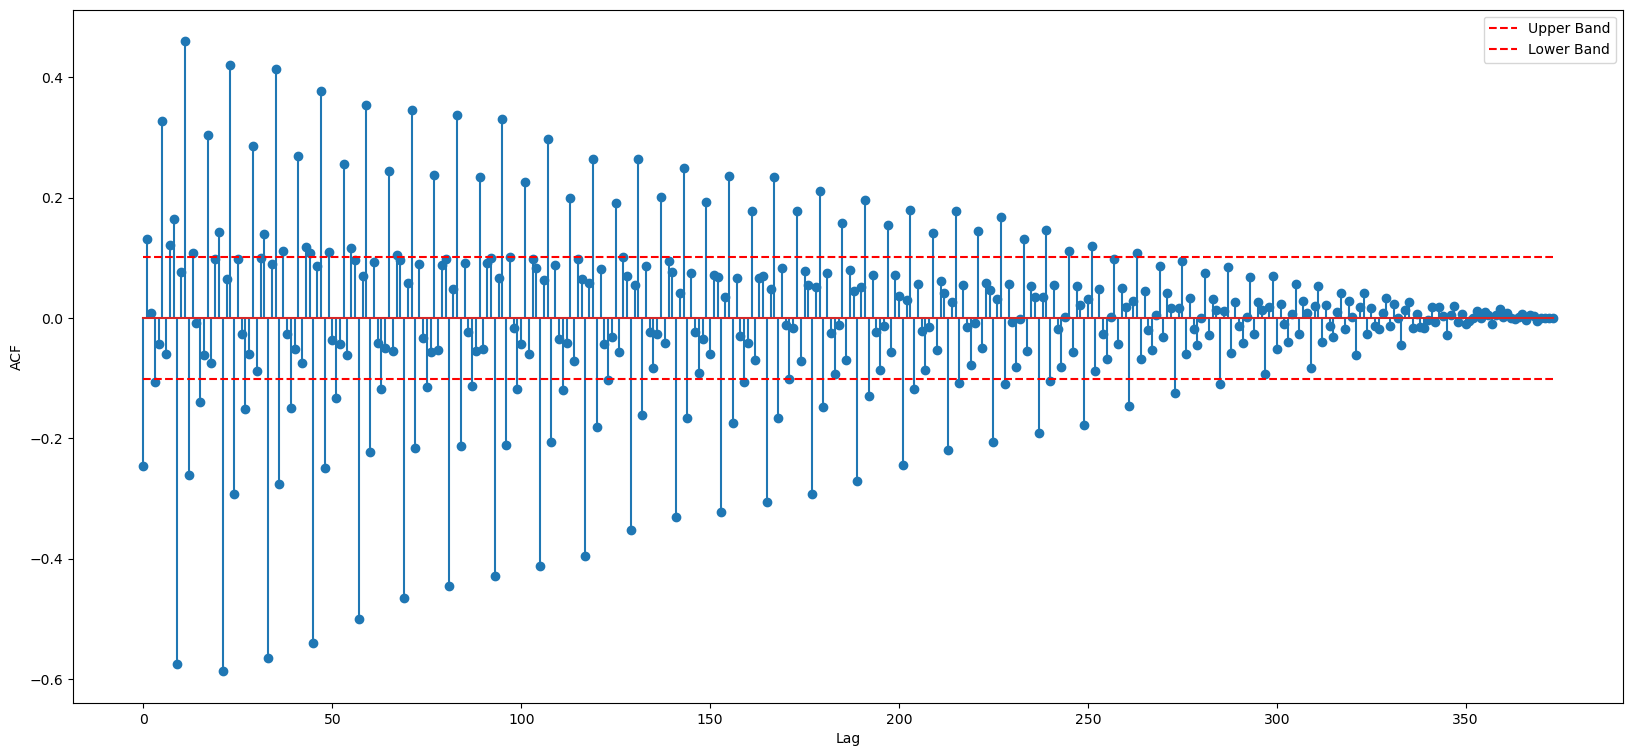

In [108]:
#Plot CCF
import statsmodels.tsa.stattools as smt
plt.figure(figsize = (20,9))

ccf_output = smt.ccf(df_diff_Inv,df_diff_Sales, unbiased=False)

plt.xlabel('Lag')
plt.ylabel('ACF')

# Calculate confidence intervals
n = len(df)
conf_level = 1.96 / np.sqrt(n)  # 95% confidence interval
upper_band = np.full(len(ccf_output), conf_level)
lower_band = -upper_band

# Plot
plt.stem(ccf_output)
plt.plot(upper_band, 'r--', label='Upper Band')
plt.plot(lower_band, 'r--', label='Lower Band')

plt.legend()
plt.show()

Interpretation: Any significant correlation between the two series decays to 0 over time.

In [109]:
#Rerun ADF test with differenced and log transformed data
adfuller(df_diff_Inv, regression = 'ct')

(-5.795524986954765,
 5.844432718763701e-06,
 14,
 359,
 {'1%': -3.984211023818932,
  '5%': -3.422790618322112,
  '10%': -3.1342831665632085},
 -2725.8806036802384)

In [110]:
adfuller(df_diff_Sales, regression = 'ct')

(-4.879975153647882,
 0.00033841133624047155,
 17,
 356,
 {'1%': -3.9844273384033553,
  '5%': -3.4228948877592487,
  '10%': -3.1343443872709296},
 -1469.0590525050106)

Based on results, we can conclude that neither series has a unit root.

In [111]:
#Create new df with transformed vars
df_diff_Sales = pd.DataFrame(df_diff_Sales, columns=["Sales"])
df_diff_Inv = pd.DataFrame(df_diff_Inv, columns=["Inv"])
df_diff = pd.concat([df_diff_Sales, df_diff_Inv], axis=1)

In [112]:
from statsmodels.tsa.api import VAR
#Fit a VAR model
model = VAR(df_diff[['Sales', 'Inv']])
#Select model order
model.select_order()
results = model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 19, May, 2023
Time:                     15:22:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -17.3923
Nobs:                     359.000    HQIC:                  -17.7962
Log likelihood:           2285.50    FPE:                1.43132e-08
AIC:                     -18.0629    Det(Omega_mle):     1.21282e-08
--------------------------------------------------------------------
Results for equation Sales
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.006749         0.001800            3.750           0.000
L1.Sales         -0.223345         0.055707           -4.009           0.000
L1.Inv            0.374120         0.322894            1.159           0.247

Text(0.5, 1.0, 'VAR Model Residuals')

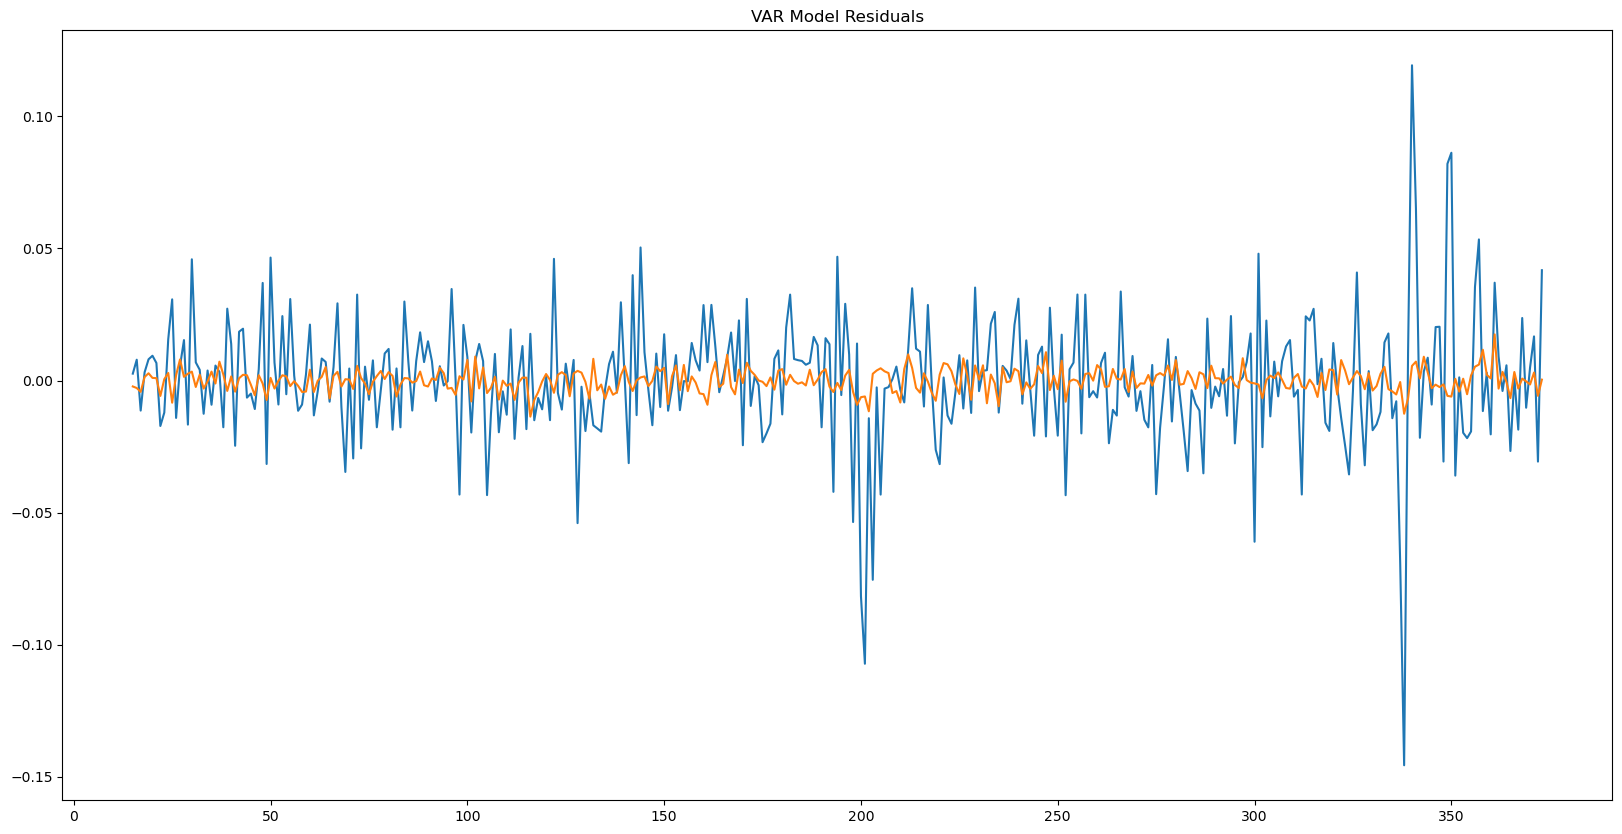

In [113]:
#Plot resisduals.
plt.figure(figsize = (20,10))
plt.plot(results.resid)
plt.title('VAR Model Residuals')

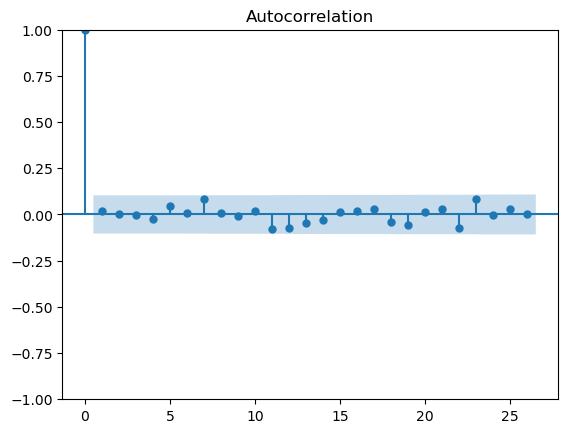

In [114]:
#Plot pacf and acf of residuals
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot

plot_acf(results.resid['Sales'])
plt.show()

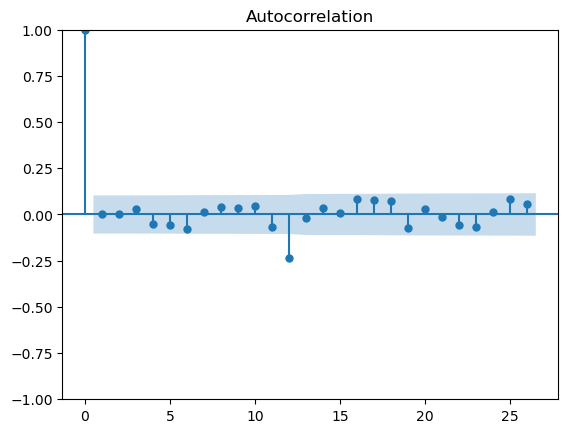

In [115]:
plot_acf(results.resid['Inv'])
plt.show()

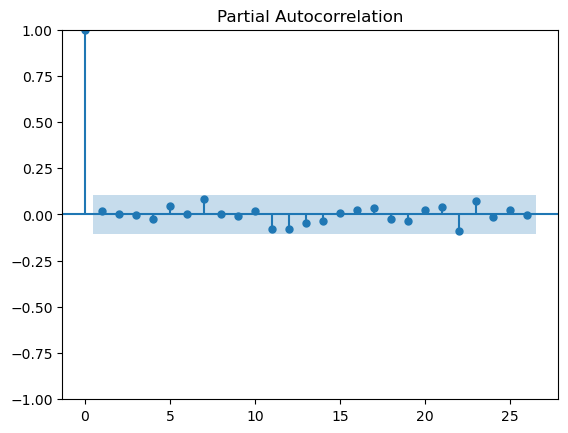

In [116]:
#plot pacf of residuals
plot_pacf(results.resid['Sales'], method = 'ywm')
plt.show()

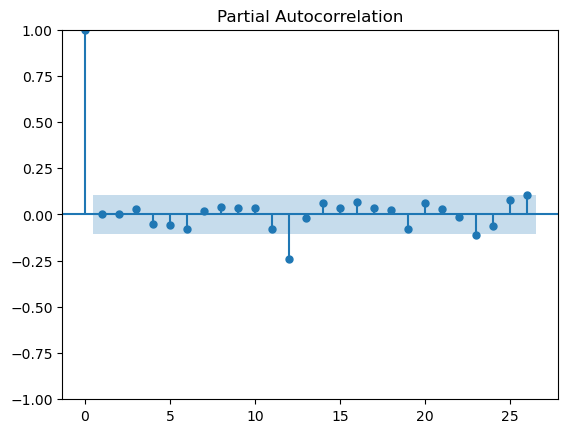

In [117]:
plot_pacf(results.resid['Inv'], method = 'ywm')
plt.show()

Based on the fitted VAR model using the select_order function to determine the optimal p, it appears that the series do not in fact contain information about each other. Because the optimal VAR model includes 15 time lags, we can conclude that the VAR Model is likely not apporpriate for our data. Additionally, after plotting the ACF and PACF of the residauals of both Inventory and Sales after fitting the VAR model, both indicate that a few dynamics might remain. Namely, in Inventory, we still see a spike at the 12th lag, indicating some cyclicity is not accounted for. 

#### l) Compute, plot, and interpret the respective impulse response functions.

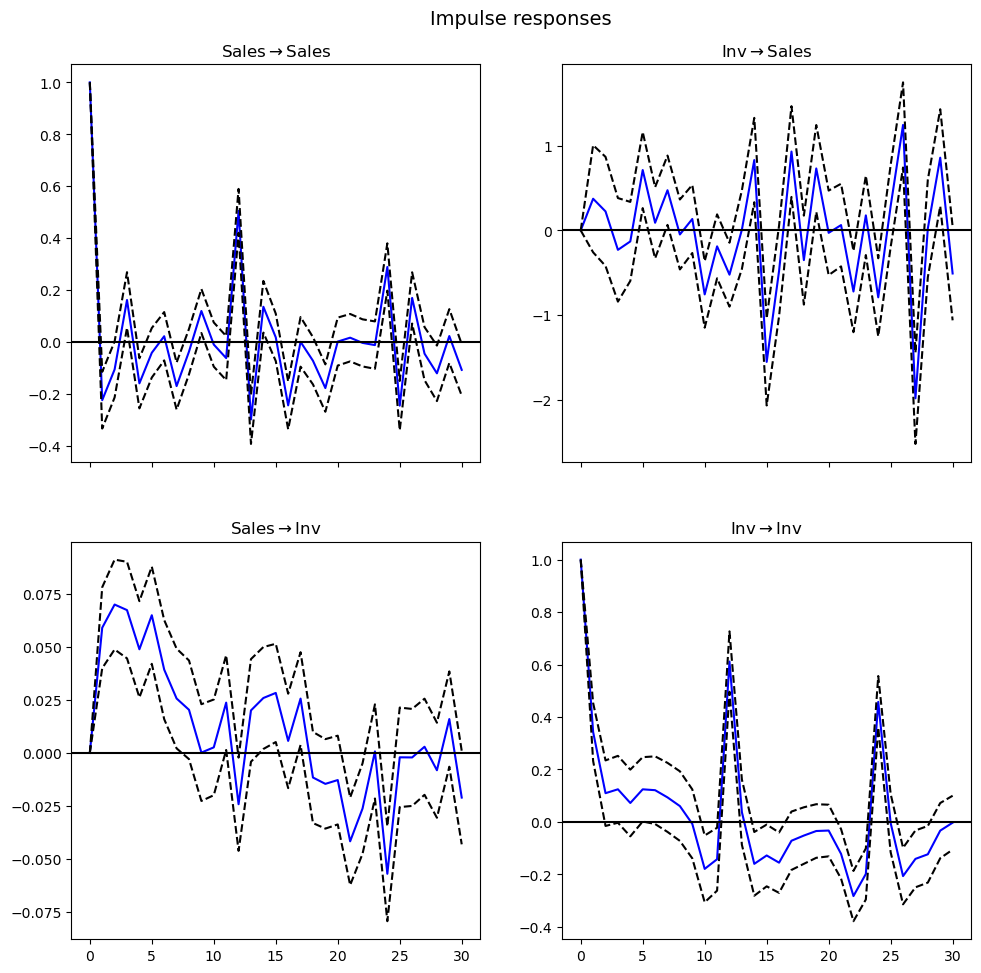

In [118]:
# IRFs
irf = results.irf(30)
#Plots
irf.plot(orth=False)
plt.show()

First looking at the effect of inventory on sales, while there appear to be some spikes at a few time lags, the effects do not exhibit a clear or persistent pattern over time. The effects of sales on inventory peak in the first 3 lags, and again seem to have negative effects at the 24th lag (2 year) mark, however for the most part the effects oscillate around 0.

Looking at the Inventory on Inventory IRF plot, there seem to be significnat peaks at the year mark, again indiciating there are some cyclical dynamics that have not been accounted for. An ARMA or distribtued lag model might be more appropriate in this case.

#### m) Perform a Granger-Causality test on your variables and discuss your results from the test.

In [119]:
# Do total business inventories cause total business sales?
results.test_causality('Sales','Inv', kind='f').summary()

Test statistic,Critical value,p-value,df
10.03,1.682,0.000,"(15, 656)"


In [120]:
# Do total business sales cause total business inventories?
results.test_causality('Inv','Sales', kind='f').summary()

Test statistic,Critical value,p-value,df
8.560,1.682,0.000,"(15, 656)"


Since both p-values are close to 0 and we reject the null in both causal questions, the results are inconclusive. We therefore cannot determine if total business inventory causes change in sales over time or if total sales cause changes in business inventory. 

#### n) Use VAR Model to forecast 12 steps ahead

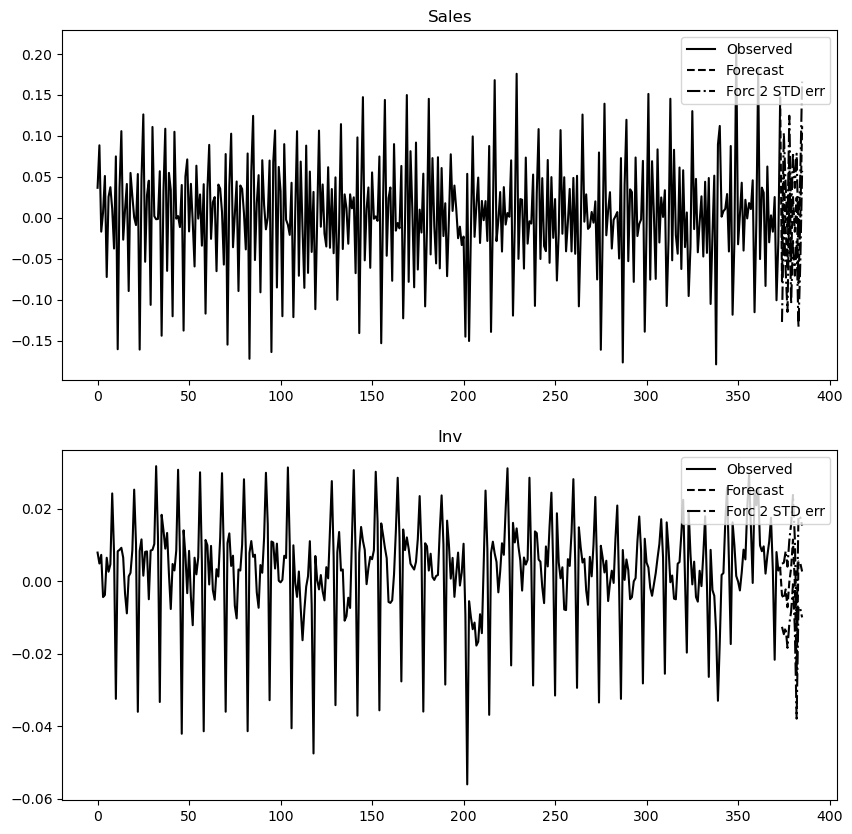

In [121]:
results.plot_forecast(12)
plt.show()

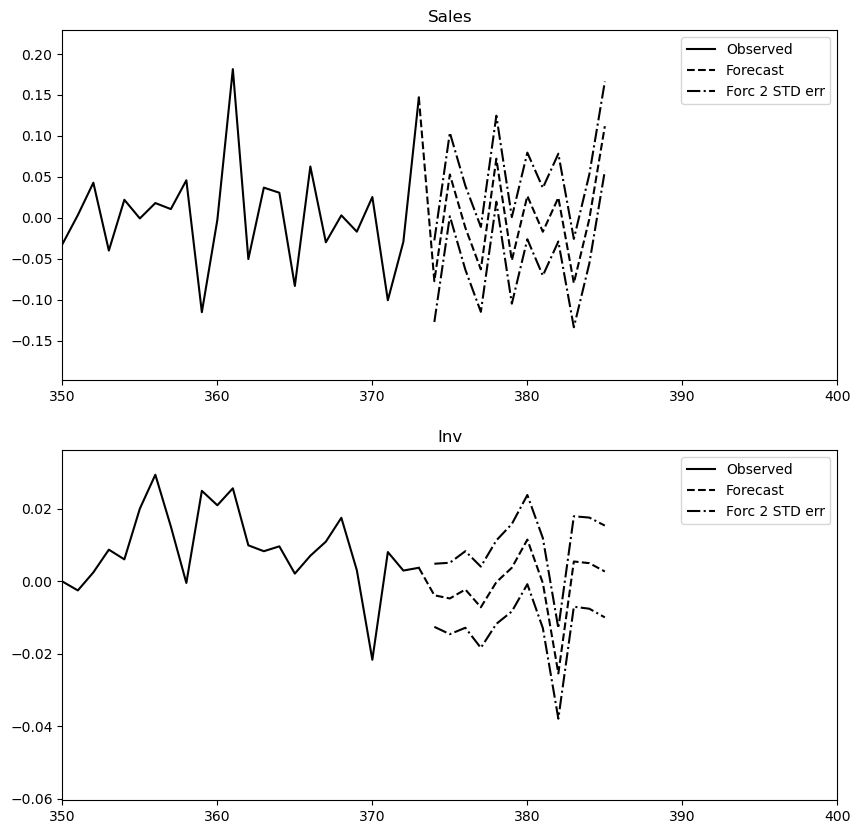

In [122]:
#Zoom in on end of series to see forecast more clearly
results.plot_forecast(12)
# Set the x-axis limits for each subplot
for ax in plt.gcf().get_axes():
    ax.set_xlim(350, 400)

In [123]:
#Calculate predictions
prediction = results.fittedvalues
predicted_sales = prediction['Sales']
predicted_inventory = prediction['Inv']

In [124]:
from sklearn.metrics import mean_absolute_percentage_error

MAPE_sales = mean_absolute_percentage_error(df_diff_Sales[15:], predicted_sales)
print(MAPE_sales)

1.377418813095628


In [125]:
MAPE_inv = mean_absolute_percentage_error(df_diff['Inv'][15:], predicted_inventory)
print(MAPE_inv)

1.3421146483287663


Based on the two MAPEs above for Sales and Inventory, compared to our earlier predictions the VAR model does not perform as well as the AutoARIIMA model for both sales and inventory.

#### o) Plot the FEVD and discuss the results

FEVD for Sales
        Sales       Inv
0    1.000000  0.000000
1    0.996106  0.003894
2    0.994756  0.005244
3    0.993461  0.006539
4    0.993179  0.006821

FEVD for Inv
        Sales       Inv
0    0.045689  0.954311
1    0.167481  0.832519
2    0.267648  0.732352
3    0.340229  0.659771
4    0.372095  0.627905




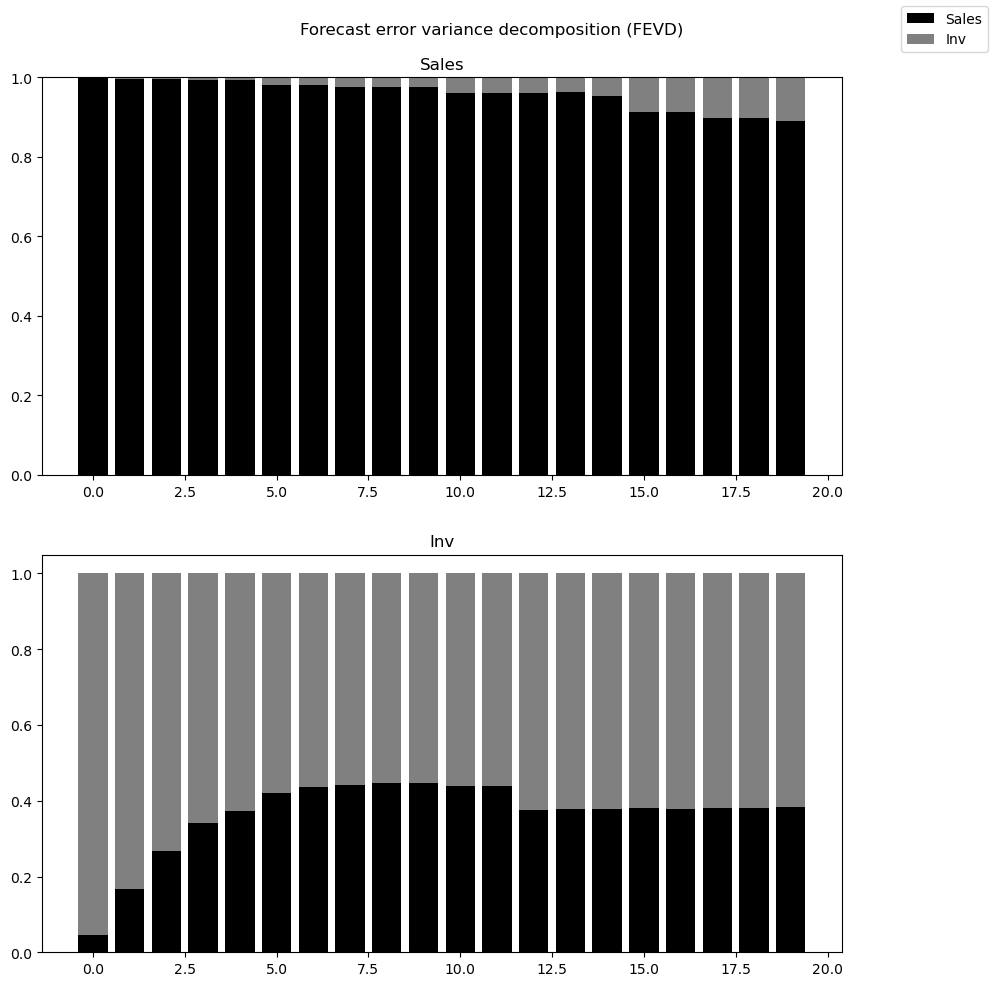

In [ ]:
# FEVD
fevd = results.fevd(5)
fevd.summary()
results.fevd(20).plot()
plt.show()

For the most part, the two series over time do not seem to explain each other's forecast error variances. The influence of sales on sales are much stronger than inventory on sales. Looking at the effects on inventory, sales seems to have an increasing effect on inventory and levels out around 12 months. If anything, sales seems to effect inventory's forecast more than the reverse, but there is still not a strong enough causal relatinoship to be conclusive. This is expected given the results of our VAR model.

## Conclusion

We have analyzed and decomposed the monthly time series data of 'Total Business Sales' and 'Total Business Inventories' obtained from FRED, which ranges from 1992 to 2023. The goal was to identify the relationships between the series and capture the underlying dynamics for forecasting purposes.

The analysis revealed that both series exhibited a linearly increasing trend over time, clear seasonality (more pronounced in sales), and cycles corresponding to recession periods. To equalize variance over time, a log transformation was applied to the data. 

Autocorrelation function (ACF) and partial autocorrelation function (PACF) plots were used to determine the appropriate models. For the sales series, a seasonal autoregressive (S-AR) process of order ~4 was identified, with significant spikes in the PACF at lags 1-5 and 12, 24, and 36. For the inventories series, a seasonal autoregressive (SAR) process of order 1 was identified, with a significant spike at lag 1 and slight spikes at 12, 24, and 36.

To capture the trend, seasonality, and cyclical dynamics, seasonal ARIMA (SARIMA) models were fitted to both series. The order of the models was determined based on the ACF and PACF plots. For the sales series, we implemented a SARIMA model with a first difference then included an AR(4) component for cycles, a seasonal AR(3) component for seasonality, and a linear trend. For the inventories series, the SARIMA model included an AR(1) component for cycles, a seasonal AR(3) component for seasonality, and a linear trend.

The diagnostic tests and p-values of the model parameters indicated the statistical significance of most coefficients and the residuals of the models were centered around 0, with some outliers causing non-constant variance. The overall fit of the models was deemed satisfactory.

For completeness we considered autoarima, ETS, and Holt-Winters forecasts of the total business sales and total inventories series. Based on a test forecast of the last 12 observed values, MAPEs for the sales models ranged from 0.11% to 0.27%. The best performing model was the autoarima fit with parameters (1,0,1)(0,1,1)[12].  When testing the forecast of the last 12 observed values for inventories, MAPEs ranged from 0.04% to 0.67%. The best performing model was the autoarima fit with parameters (3,0,2)(1,1,1)[12].

A vector autoregression (VAR) model was fit to capture the interdependencies and feedback effects between the two series. However, after fitting the VAR model with 15 time lags and examining the ACF and PACF of the residuals, it was determined that the VAR model was not suitable for the data. The effects of inventory on sales and sales on inventory did not exhibit clear or persistent patterns over time, suggesting a lack of strong causal relationships.

In conclusion, while the  models provided forecasts for future economic activity, the VAR model did not yield conclusive results regarding the causal relationships between total business sales and inventories.

## References

Federal Reserve Bank of St. Louis. (2021). Total Business Inventories [Data set]. FRED, Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/BUSINV

Federal Reserve Bank of St. Louis. (2021). Total Business Sales [Data set]. FRED, Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/TOTBUSSMSA

Kunz, N. (2023). Econ 412, Course Material. Retrieved from BruinLearn 

Rojas, R. (2023). Econ 412, Course Material. Retrieved from BruinLearn


